# Packages

In [107]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
import scipy.stats as stats
import math as math

In [108]:
# a slide a minute, talk for 3-5 minutes
# replace -9999 values with 0 for a more accurate example

# Function

In [265]:
def get_r2(x,y):
    polyfit = np.polyfit(x,y,1)
    y_predicted = np.polyval(polyfit,x)
    residuals = y-y_predicted
    return 1-np.sum(residuals**2)/np.sum((y-np.mean(y))**2)
def best_fit(X,Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X)

    numer = sum([xi*yi for xi,yi in zip(X,Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar
    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a,b))
    return a, b
def parascatter(df,xs,ys,xerrs=None,yerrs=None,size=3,
                s=None,lw=None,color=None,scale='linear'):
    plt.figure(figsize=(len(ys)*size,len(xs)*size))
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.subplot(len(xs),len(ys),j+i*len(ys)+1)
            plt.scatter(df[xs[i]],df[ys[j]],
                        s=s,color=color,lw=lw)
            if xerrs:
                plt.plot([df[xs[i]]-df[xerrs[i]],df[xs[i]]+df[xerrs[i]]],
                         [df[ys[j]],df[ys[j]]],
                         color=color,lw=lw)
            if yerrs:
                plt.plot([df[xs[i]],df[xs[i]]],
                         [df[ys[j]]-df[yerrs[i]],df[ys[j]]+df[yerrs[i]]],
                         color=color,lw=lw)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel(xs[i])
            plt.ylabel(ys[j])
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray()).T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

# Read Data

### ROCKCHIP

In [266]:
data = pd.read_csv('GEOCHEM_ROCKCHIPS.csv')

/var/folders/n3/ff_b_tgs4kz692m1nls0vmk00000gn/T/ipykernel_70980/2067541088.py:1: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('GEOCHEM_ROCKCHIPS.csv')


In [267]:
data.replace(-9999.0, 0, inplace=True)

In [268]:
new_array = data.values

In [269]:
data.to_csv('edited_Geochem_RC.csv', index=False)

In [270]:
#create new dataframe only including rows where PT_PPM & PD_PPM column value >= 0
new_df = data[(data["PT_PPM"] > -1) & (data["PD_PPM"] > -1)]#& (data["RU_PPM"] >0) & (data["S_PPM"] >0)  # & Ru, Rh, Os, Ir compared to S
new_df2 = data[(data["AU_PPM"] > 0) & (data["PT_PPM"] > 0)]
#View PT_PPM and PD_PPM columns
new_df[['PT_PPM','PD_PPM']]

,PT_PPM,PD_PPM
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
38598,0.0,0.0
38599,0.0,0.0
38600,0.0,0.0
38601,0.0,0.0


In [271]:
lon = data['LONGITUDE']
lat = data['LATITUDE']
Pt = data['PT_PPM']
Pd = data['PD_PPM']
S = data['S_PPM']
Ru = data['RU_PPM']

### WHOLE ROCK

In [272]:
data2 = pd.read_csv('GEOCHEM_WHOLEROCK.csv')

/var/folders/n3/ff_b_tgs4kz692m1nls0vmk00000gn/T/ipykernel_70980/2144643680.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('GEOCHEM_WHOLEROCK.csv')


In [273]:
data2.replace(-9999.0, 0, inplace=True)
data2.replace(-9999, 0, inplace=True)

In [274]:
new_array = data2.values

In [275]:
data2.to_csv('edited_Geochem_WR.csv', index=False)

In [276]:
lon2 = data2['LONGITUDE']
lat2 = data2['LATITUDE']

### SOIL

In [277]:
data3 = pd.read_csv('GEOCHEM_SOILS.csv')

/var/folders/n3/ff_b_tgs4kz692m1nls0vmk00000gn/T/ipykernel_70980/1168893972.py:1: DtypeWarning: Columns (2,3,9,10,11,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('GEOCHEM_SOILS.csv')


In [278]:
data3.replace(-9999.0, 0, inplace=True)
data3.replace(-9999, 0, inplace=True)

In [279]:
new_array = data3.values

In [280]:
data3.to_csv('edited_Geochem_S.csv', index=False)

In [281]:
lon3 = data3['LONGITUDE']
lat3 = data3['LATITUDE']

# Analysis

### ROCKCHIP

In [205]:
get_r2(data['PT_PPM'],data['PD_PPM'])

0.37300509343612087

In [206]:
get_r2(data['PT_PPM'],data['AU_PPM'])

2.939346092967199e-06

In [207]:
stats.linregress(data['PT_PPM'],data['PD_PPM'])

LinregressResult(slope=0.6441678544578893, intercept=0.028072250946409343, rvalue=0.6107414292776595, pvalue=0.0, stderr=0.004250836452377101, intercept_stderr=0.0032844430916317614)

In [208]:
best_fit(data['PT_PPM'],data['PD_PPM'])

best fit line:
y = 0.03 + 0.64x


(0.02807225094640931, 0.6441678544578869)

In [209]:
tempcoeffs = best_fit(data['PT_PPM'],data['PD_PPM'])
tempPT = np.logspace(np.log10(data['PT_PPM'][data['PT_PPM']>0].min()),np.log10(data['PT_PPM'].max()),100)
tempPD = tempcoeffs[1]*tempPT+tempcoeffs[0]

best fit line:
y = 0.03 + 0.64x


In [210]:
fitline = (np.unique(data['PT_PPM']), np.poly1d(np.polyfit(data['PT_PPM'],data['PD_PPM'],deg=1))(np.unique(data['PT_PPM'])))

### WHOLE ROCK

In [333]:
get_r2(data2['PT_PPM'],data2['PD_PPM'])

0.756028398569014

In [334]:
best_fit(data2['PT_PPM'],data2['PD_PPM'])

best fit line:
y = -0.00 + 0.98x


(-0.001011168531093506, 0.9824346573815417)

### SOIL

In [335]:
get_r2(data3['PT_PPM'],data3['PD_PPM'])

0.057545118541485585

In [336]:
best_fit(data3['PT_PPM'],data3['PD_PPM'])

best fit line:
y = 0.01 + 0.15x


(0.014189874343844425, 0.14893686360950342)

## PLOTS

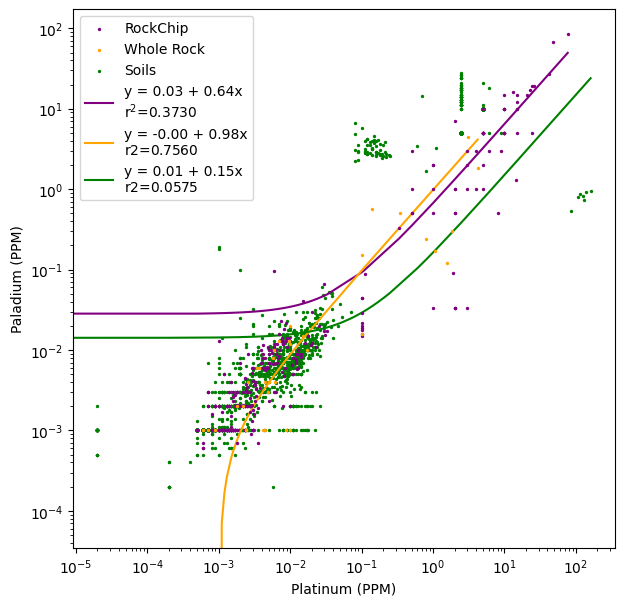

In [337]:
plt.figure(figsize = (7,7))
plt.scatter(data['PT_PPM'],data['PD_PPM'],s=2, c = 'purple', zorder = 5, label='RockChip')
plt.scatter(data2['PT_PPM'],data2['PD_PPM'],s=2, c = 'orange', zorder = 10, label='Whole Rock')
plt.scatter(data3['PT_PPM'],data3['PD_PPM'],s=2, c = 'green', zorder = 0, label='Soils')
plt.xlabel('Platinum (PPM)')
plt.ylabel('Paladium (PPM)')
plt.xscale('log')
plt.yscale('log')
plt.plot(np.unique(data['PT_PPM']), np.poly1d(np.polyfit(data['PT_PPM'],data['PD_PPM'],deg=1))(np.unique(data['PT_PPM'])),c = 'purple', label='y = 0.03 + 0.64x\nr$^2$=0.3730')
plt.plot(np.unique(data2['PT_PPM']), np.poly1d(np.polyfit(data2['PT_PPM'],data2['PD_PPM'],deg=1))(np.unique(data2['PT_PPM'])),c = 'orange', label='y = -0.00 + 0.98x\nr$2$=0.7560')
plt.plot(np.unique(data3['PT_PPM']), np.poly1d(np.polyfit(data3['PT_PPM'],data3['PD_PPM'],deg=1))(np.unique(data3['PT_PPM'])),c = 'green', label='y = 0.01 + 0.15x\nr$2$=0.0575')
plt.legend(loc='upper left', fontsize="medium")
plt.savefig('PlatinumPaladiumPlot')

### Writing

In [196]:
#q = np.polyfit(np.log(tempPT),np.log(tempPD),1)

In [167]:
#need to plot the ratios of Pt:Pd and find that line of best fit
#discussion about detection limits and its affect on the data
#also the tendency for data to be rounded at higher values due to the sensitivity of detection methods, smaller values tend to be more accurate

In [168]:
# compare platinum content and correlations with all platinum group minerals 

In [169]:
#parascatter(data,['PT_PPM'],['PD_PPM','RU_PPB','OS_PPB','S_PPM'],lw=1)

In [170]:
# setting new dataframe to remove values where content was not detected at any level but it does mean removing the ability to note the lack of correlation between S and platinum group minerals?
# or should I just look at the correlations between platinum group elements in data sets in NT and potentially include geospatial data for demonstrating regions of high ore correlations
# how to put georeferenced data on georeferenced images
# plotting georeferenced points where depending on Pt group values the scatters are different
# possibly compare Pt high value areas and S high value areas, using histograms to only plot top bins or quartiles
# use qgis to create georeferenced satellite imagery 

# TIFF

In [285]:
dataset = gdal.Open(r'GeoTiff.tiff')
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(dataset)

## Long Lat Plots

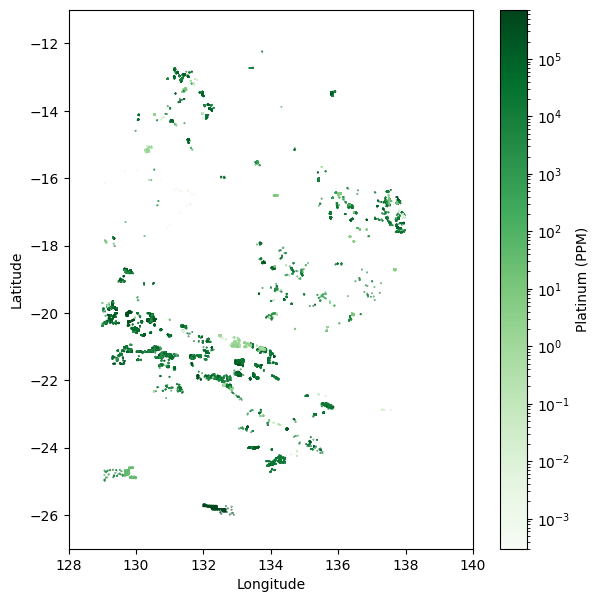

In [348]:
plt.figure(figsize = (7,7))
plt.scatter(lon,lat,s=0.1,c=data['FE_PPM'],cmap="Greens", norm='log', label='Rockchip', zorder=10)
plt.scatter(lon2,lat2,s=0.1,c=data2['FE_PPM'],cmap="Greens", norm='log', label='WholeRock', zorder=15)
plt.scatter(lon3,lat3,s=0.1,c=data3['FE_PPM'],cmap="Greens", norm='log', label='Soils', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('square')
plt.axis([128,140, -27, -11])
plt.colorbar(label = 'Platinum (PPM)')
#plt.legend()
plt.savefig('GeoFE')

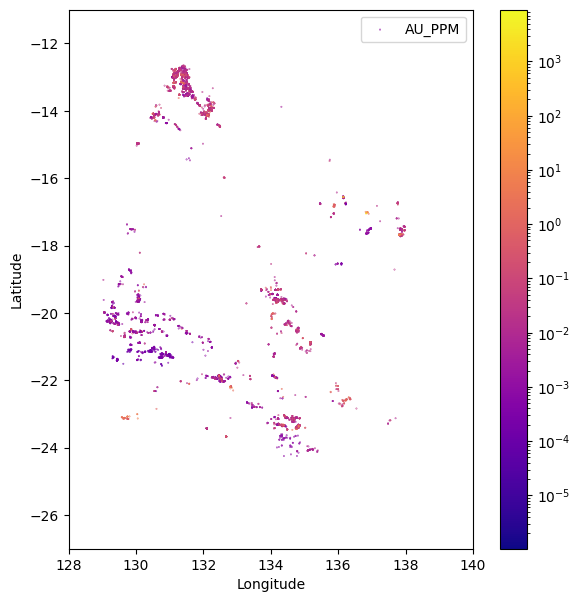

In [241]:
plt.figure(figsize = (7,7))
plt.scatter(lon,lat,s=0.1,c=data['AU_PPM'],cmap="plasma", norm = 'log')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('square')
plt.axis([128,140, -27, -11])
plt.colorbar()
plt.legend(['AU_PPM'])
#plt.savefig('GeoAU')

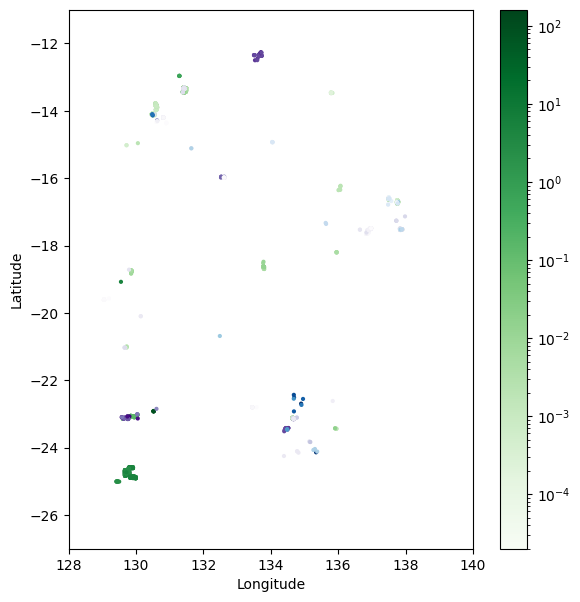

In [325]:
plt.figure(figsize = (7,7))
plt.scatter(lon,lat,s=4,c=data['PT_PPM'],cmap="Purples", norm='log', label='Rockchip', zorder=10)
plt.scatter(lon2,lat2,s=4,c=data2['PT_PPM'],cmap="Blues", norm='log', label='WholeRock', zorder=15)
plt.scatter(lon3,lat3,s=4,c=data3['PT_PPM'],cmap="Greens", norm='log', label='Soils', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('square')
plt.axis([128,140, -27, -11])
plt.colorbar()
#plt.savefig('GeoPT')

/var/folders/n3/ff_b_tgs4kz692m1nls0vmk00000gn/T/ipykernel_70980/581777003.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, 1000, 0.0001, 100])


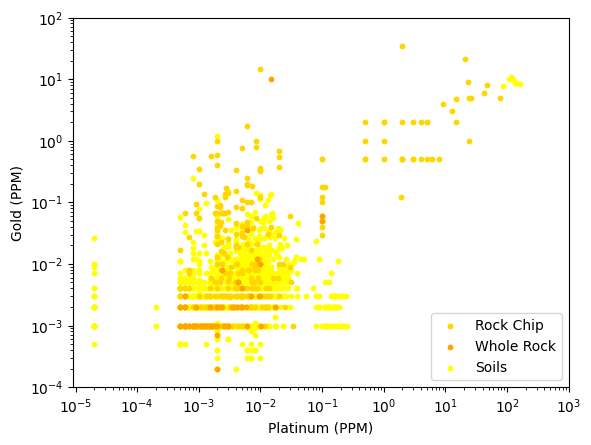

In [347]:
plt.scatter(data['PT_PPM'],data['AU_PPM'],s=10, c = 'gold', zorder=5, label = 'Rock Chip')
plt.scatter(data2['PT_PPM'],data2['AU_PPM'],s=10, c = 'orange', zorder=10, label = 'Whole Rock')
plt.scatter(data3['PT_PPM'],data3['AU_PPM'],s=10, c = 'yellow', zorder=0, label = 'Soils')
plt.xlabel('Platinum (PPM)')
plt.ylabel('Gold (PPM)')
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1000, 0.0001, 100])
#plt.plot(np.unique(data2['PT_PPM']), np.poly1d(np.polyfit(data2['PT_PPM'],data2['AU_PPM'],deg=1))(np.unique(data2['PT_PPM'])),c='orange', label = "y = 0.73 + 0.12x")
#plt.plot(np.unique(data3['PT_PPM']), np.poly1d(np.polyfit(data3['PT_PPM'],data3['AU_PPM'],deg=1))(np.unique(data3['PT_PPM'])),c='yellow', label = "y = 0.73 + 0.12x")
plt.legend(loc='lower right')
plt.savefig('PlatinumGoldPlot')

In [137]:
get_r2(data['PT_PPM'],data['AU_PPM'])

2.939346092967199e-06

0.000002939346092967199

In [138]:
best_fit(data['PT_PPM'],data['AU_PPM'])

best fit line:
y = 0.73 + 0.12x


(0.7285389169155903, 0.11519588073693056)

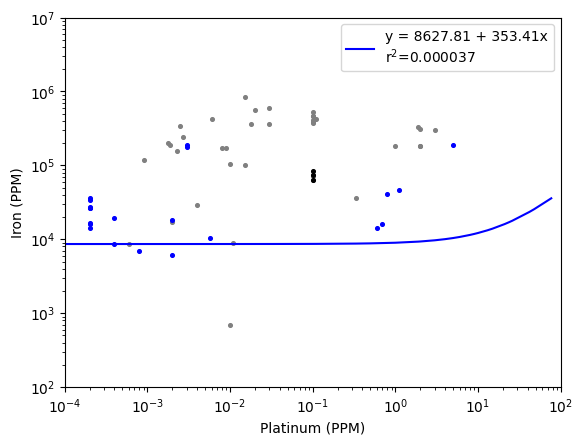

In [324]:
plt.scatter(data['PT_PPM'],data['FE_PPM'],s=7, c = 'grey')
plt.scatter(data2['PT_PPM'],data2['FE_PPM'],s=7, c = 'black')
plt.scatter(data3['PT_PPM'],data3['FE_PPM'],s=7, c = 'blue')
plt.xlabel('Platinum (PPM)')
plt.ylabel('Iron (PPM)')
plt.xscale('log')
plt.yscale('log')
plt.axis([0.0001, 100, 100, 10000000])
plt.plot(np.unique(data['PT_PPM']), np.poly1d(np.polyfit(data['PT_PPM'],data['FE_PPM'],deg=1))(np.unique(data['PT_PPM'])),c='blue', label = 'y = 8627.81 + 353.41x\nr$^2$=0.000037')
plt.legend()
#plt.savefig('PlatinumIronPlot')

In [140]:
get_r2(data['PT_PPM'],data['FE_PPM'])

3.612099864780394e-05

0.00003612099864780394

In [141]:
best_fit(data['PT_PPM'],data['FE_PPM'])

best fit line:
y = 8627.81 + 353.41x


(8627.810550203207, 353.4060859012581)

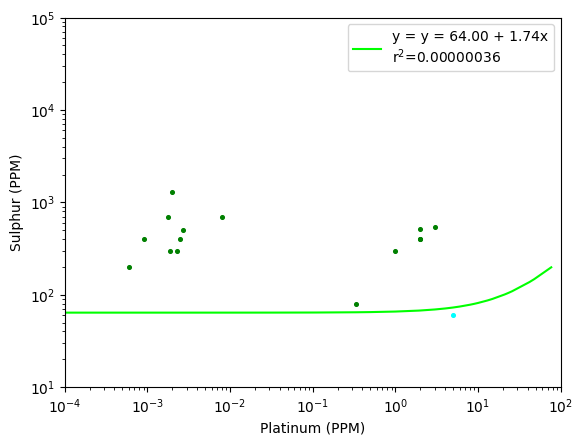

In [322]:
plt.scatter(data['PT_PPM'],data['S_PPM'],s=7, c = 'green')
plt.scatter(data2['PT_PPM'],data2['S_PPM'],s=7, c = 'lime')
plt.scatter(data3['PT_PPM'],data3['S_PPM'],s=7, c = 'cyan')
plt.xlabel('Platinum (PPM)')
plt.ylabel('Sulphur (PPM)')
plt.xscale('log')
plt.yscale('log')
plt.axis([0.0001, 100, 10, 100000])
plt.plot(np.unique(data['PT_PPM']), np.poly1d(np.polyfit(data['PT_PPM'],data['S_PPM'],deg=1))(np.unique(data['PT_PPM'])),c='lime', label = 'y = y = 64.00 + 1.74x\nr$^2$=0.00000036')
plt.legend()
#plt.savefig('PlatinumSulphurPlot')

In [143]:
get_r2(data['PT_PPM'],data['S_PPM'])

3.665453603973745e-07

In [144]:
best_fit(data['PT_PPM'],data['S_PPM'])

best fit line:
y = 64.00 + 1.74x


(63.99727929990349, 1.7414593279425932)